# Zestaw 4. Kwadratury 

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.special

## 1. Kwadratury elementarne
Napisz funkcję, która policzy prostą, zamkniętą kwadraturę Simpsona

In [25]:
def simpson_quadrature(f, a, b):
    h = b - a
    middle = (a + b)/2
    return h*(f(a) + 4*f(middle) + f(b))/6

a. Przetestuj jej działanie na jednomianach kolejnych stopni, nie większych niż 5
poprzez porównanie wyników z wartościami analitycznymi. Opisz wyniki.

In [26]:
def test_simpson():
    def monomial(i):
        return lambda x: x**i
    
    for i in range(6):
        simpson = simpson_quadrature(monomial(i), 0, 1)
        actual = 1/(i+1)*monomial(i+1)(1)
        print(f"x^{i}: expected: {actual:.2f}, got: {simpson:.2f}")

In [27]:
test_simpson()

x^0: expected: 1.00, got: 1.00
x^1: expected: 0.50, got: 0.50
x^2: expected: 0.33, got: 0.33
x^3: expected: 0.25, got: 0.25
x^4: expected: 0.20, got: 0.21
x^5: expected: 0.17, got: 0.19


b. Przetestuj jej działanie na funkcji $f(x) = e^{−3x} sin(4x)$ na przedziale x ∈ [0, 5]
poprzez wyliczenie jej wartości na całym przedziale, a następnie porównanie z sumą
metody na dwóch podprzedziałach [0, 1] i [1, 5]. Czemu wyniki się różnią?

In [29]:
f = lambda x: np.e**(-3*x)*np.sin(4*x)
print("        [0,5] ->", simpson_quadrature(f, 0, 5))
print("[0,1] + [1,5] ->", simpson_quadrature(f, 0, 1) + simpson_quadrature(f, 1, 5))

        [0,5] -> -0.0010027325181523326
[0,1] + [1,5] -> 0.10368557622593555


c. Zaprezentuj na wykresie funkcję f oraz kwadratowy wielomian interpolujący ją w
węzłach będących końcami przedziału i jego środkiem. Oblicz kwadraturę wyliczonego w ten sposób wielomianu i porównaj wyniki. W jaki sposób ten wielomian
jest powiązany z metodą Simpsona?

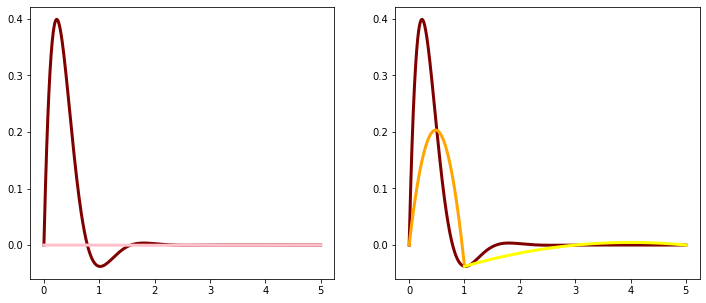

In [30]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

def plot_interpolation(ax, f, interval, color):
    x_axis = np.linspace(interval[0], interval[1], 500)
    ax.plot(x_axis, f(x_axis), color='maroon', linewidth=3)
    
    points = [interval[0], (interval[0]+interval[1])/2, interval[1]]
    interpolation = scipy.interpolate.interp1d(points, list(map(f, points)), kind='quadratic')
    ax.plot(x_axis, interpolation(x_axis), color=color, linewidth=3)


plot_interpolation(ax[0], f, [0, 5], "pink")
plot_interpolation(ax[1], f, [0, 1], "orange")
plot_interpolation(ax[1], f, [1, 5], "yellow")

porównaj wyniki. W jaki sposób ten wielomian
jest powiązany z metodą Simpsona?

(...)

## 2. Kwadratury adaptacyjne
Zaimplementuj adaptacyjną kwadraturę Simpsona. Dla kilku różnych dokładności ε wykonaj poniższe polecenia.

In [32]:
def adaptive_quadrature(f, a, b, epsilon):
    s_q = simpson_quadrature
    mid = (a+b)/2
    diff = abs(s_q(f, a, b) - s_q(f, a, mid) - s_q(f, mid, b))
    if diff < 15*epsilon:
        return s_q(f, a, mid) + s_q(f, mid, b)
    return adaptive_quadrature(f, a, mid, epsilon/2) + adaptive_quadrature(f, mid, b, epsilon/2)

a. Przetestuj ją na funkcji f z zadania 1.b i porównaj wyniki z elementarną metodą
Simpsona

In [41]:
adaptive_quadrature(f, 0, 5, 1e-10)
#porównanie!

0.1599999465166611

b. Zaprezentuj na wykresie funkcję f oraz punkty podziału wyliczone przez metodę
adaptacyjną. Opisz wyniki.

In [112]:
def adaptive_quadrature_points(f, a, b, epsilon, points):
    s_q = simpson_quadrature
    mid = (a+b)/2
    diff = abs(s_q(f, a, b) - s_q(f, a, mid) - s_q(f, mid, b))
    
    if diff < 15*epsilon:
        points.update([a, mid, b])
        return s_q(f, a, mid) + s_q(f, mid, b)
    
    return adaptive_quadrature_points(f, a, mid, epsilon/2, points) + adaptive_quadrature_points(f, mid, b, epsilon/2, points)

In [113]:
def plot_adaptive_points(f, a, b, epsilon, ax):
    points=set()
    adaptive_quadrature_points(f, a, b, epsilon, points)

    x_axis = np.linspace(a, b, 500)
    ax.plot(x_axis, f(x_axis), color='maroon', linewidth=3)
    points = np.array(list(points))
    ax.scatter(points, f(points), zorder=5, color="darkblue")

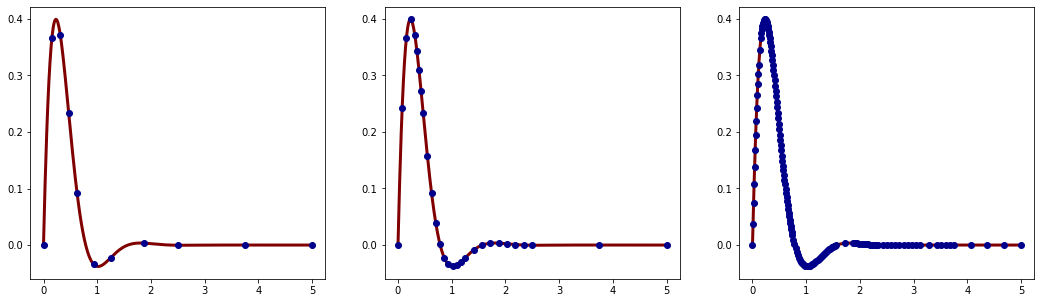

In [114]:
_, ax = plt.subplots(1, 3, figsize=(18, 5))
plot_adaptive_points(f, 0, 5, 1e-3, ax[0])
plot_adaptive_points(f, 0, 5, 1e-5, ax[1])
plot_adaptive_points(f, 0, 5, 1e-8, ax[2])

wyniki: większa dokładność => więcej punktów. punktów więcej tam gdzie funkcja jest bardziej powyginana

## 3. Wielomiany ortogonalne
Korzystając z modułu numpy.poly1d zaimplementuj wielomiany Legendre’a zdefiniowane w następujący sposób: <br>
>$$
P_0(x) = 1 \\
P_1(x) = x \\
P_{k+1}(x) = \frac{2k+1}{k+1}xP_k(x) − \frac{k}{k+1}P_{k−1}(x) 
$$

In [120]:
def legendre_poly(low, high):
    p1 = np.poly1d([1])
    p2 = np.poly1d([1,0])
    if low <= 0 <= high:
        yield p1
    if low <= 1 <= high:
        yield p2
                   
    for k in range(2, high+1):
        p2, p1 = (2*k-1)/k*np.poly1d([1, 0])*p2 - (k-1)/k*p1, p2
        yield p2

In [123]:
for x in legendre_poly(0, 5):
    print(x)

 
1
 
1 x
     2
1.5 x - 0.5
     3
2.5 x - 1.5 x
       4        2
4.375 x - 3.75 x + 0.375
       5        3
7.875 x - 8.75 x + 1.875 x


a. Zaprezentuj je na wykresie na przedziale x ∈ [−1, 1]

In [124]:
def plot_legendre(k):
    fig, ax = plt.subplots()
    x_axis = np.linspace(-1, 1, 50)
    for f in legendre_poly(0, k):
        ax.plot(x_axis, f(x_axis))

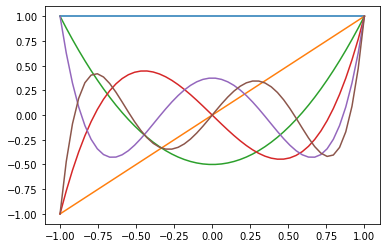

In [125]:
plot_legendre(5)

b. Sprawdź, że ich miejsca zerowe (wykorzystując pole numpy.poly1d.r) są odciętymi punktów Gaussa (scipy.special.roots legendre). Test wykonaj dla wielomianów od 2 do 4 stopnia.

In [142]:
for i, poly in enumerate(legendre_poly(2, 4)):
    print(f'-- x^{i+2} --')
    print(f'Legendre zeros: {sorted(poly.r)}')
    print(f'Gauss points x: {sorted(scipy.special.roots_legendre(i+2)[0])}')

-- x^2 --
Legendre zeros: [-0.5773502691896258, 0.5773502691896256]
Gauss points x: [-0.5773502691896257, 0.5773502691896257]
-- x^3 --
Legendre zeros: [-0.7745966692414834, 0.0, 0.7745966692414833]
Gauss points x: [-0.7745966692414834, 0.0, 0.7745966692414834]
-- x^4 --
Legendre zeros: [-0.8611363115940536, -0.33998104358485653, 0.3399810435848563, 0.8611363115940531]
Gauss points x: [-0.8611363115940526, -0.3399810435848563, 0.3399810435848563, 0.8611363115940526]


c. Podaj związek tego faktu z podstawowym twierdzeniem kwadratur Gaussa (z wykładu)

TODO

## 4. Kwadratury Gaussa

Na podstawie parametrów kwadratury Gaussa (scipy.special.roots legendre) zaimplementuj funkcję, która dla określonej liczby punktów k oraz funkcji f policzy wartość $\int_{-1}^{1}f(x)dx $

In [192]:
def gauss_quadrature(f, k):
    x_s, A_s = scipy.special.roots_legendre(k)
    integral = 0
    for A, x in zip(A_s, x_s):
        integral += A*f(x)
    return integral

Przetestuj jej działanie na jednomianach kolejnych stopni. Sprawdź kiedy przestaje być dokładna i podaj związek z twierdzeniem o stopniu dokładności kwadratury Gaussa.

In [205]:
def test_gauss(k):
    def monomial(i):
        return lambda x: x**i
    
    for i in range(2*k+5):
        gauss = gauss_quadrature(monomial(i), k)
        actual = 1/(i+1)*monomial(i+1)(1) - 1/(i+1)*monomial(i+1)(-1)
        print(f"x^{i}: expected: {actual:.3f}, got: {gauss:.3f}, difference: {abs(gauss-actual):.5f}")

In [207]:
test_gauss(5)

x^0: expected: 2.000, got: 2.000, difference: 0.00000
x^1: expected: 0.000, got: -0.000, difference: 0.00000
x^2: expected: 0.667, got: 0.667, difference: 0.00000
x^3: expected: 0.000, got: 0.000, difference: 0.00000
x^4: expected: 0.400, got: 0.400, difference: 0.00000
x^5: expected: 0.000, got: 0.000, difference: 0.00000
x^6: expected: 0.286, got: 0.286, difference: 0.00000
x^7: expected: 0.000, got: -0.000, difference: 0.00000
x^8: expected: 0.222, got: 0.222, difference: 0.00000
x^9: expected: 0.000, got: 0.000, difference: 0.00000
x^10: expected: 0.182, got: 0.179, difference: 0.00293
x^11: expected: 0.000, got: 0.000, difference: 0.00000
x^12: expected: 0.154, got: 0.146, difference: 0.00799
x^13: expected: 0.000, got: 0.000, difference: 0.00000
x^14: expected: 0.133, got: 0.119, difference: 0.01387


## 5. Kwadratury Gaussa c.d.

Korzystając z rozwiązań z poprzedniego zadania napisz
funkcję liczącą całkę w dowolnym przedziale $\int_{a}^{b}f(x)dx$ dokonując normalizacji.

In [208]:
def gauss_quadrature_interval(f, k, a, b):
    return gauss_quadrature(
        lambda x: f((b+a)/2 + (b-a)/2*x), k)*(b-a)/2

Przetestuj działanie na kilku przykładach i sprawdź z wynikami otrzymanymi analitycznie.

In [209]:
def test_gauss_interval(k, a, b):
    def monomial(i):
        return lambda x: x**i
    
    for i in range(2*k+5):
        gauss = gauss_quadrature_interval(monomial(i), k, a, b)
        actual = 1/(i+1)*monomial(i+1)(b) - 1/(i+1)*monomial(i+1)(a)
        print(f"x^{i}: expected: {actual:.3f}, got: {gauss:.3f}, difference: {abs(gauss-actual):.5f}")

In [211]:
test_gauss_interval(4, -3, 10)

x^0: expected: 13.000, got: 13.000, difference: 0.00000
x^1: expected: 45.500, got: 45.500, difference: 0.00000
x^2: expected: 342.333, got: 342.333, difference: 0.00000
x^3: expected: 2479.750, got: 2479.750, difference: 0.00000
x^4: expected: 20048.600, got: 20048.600, difference: 0.00000
x^5: expected: 166545.167, got: 166545.167, difference: 0.00000
x^6: expected: 1428883.857, got: 1428883.857, difference: 0.00000
x^7: expected: 12499179.875, got: 12499179.875, difference: 0.00000
x^8: expected: 111113298.111, got: 110872833.273, difference: 240464.83839
x^9: expected: 999994095.100, got: 992419452.691, difference: 7574642.40929
x^10: expected: 9090925195.182, got: 8935806636.900, difference: 155118558.28144
x^11: expected: 83333289046.583, got: 80763501434.919, difference: 2569787611.66458
x^12: expected: 769230891871.000, got: 731716660457.657, difference: 37514231413.34314


zgadza się

M. Hawryluk 12.04.2021